## Chapter 7 Linear multi-class classification

# 7.3 Which approach produces the best results?

We have now seen two fundamental approaches to linear multi-class classification: the One-versus-All (OvA) and the Multi-class Perceptron / Softmax.  Both approaches are commonly used in practice and can - depending on the dataset - produce similarly good results.  Howver the latter approach (the Multi-class Perceptron / Softmax) is - at least in principle - capable of achieving higher accuracy on a broader range of datasets.  Why is this?

Remember that with OvA (as we saw in Section 7.1) we solve a sequence of $C$ two class subproblems (one per class) tuning the weights of each classifier $\mathbf{w}_0,\,\mathbf{w}_1,\,...,\mathbf{w}_{C-1}$ independently.  We then combine the results of our $C$ tuned classifiers via the fusion rule to produce the predicted output $y$ for a point $\mathbf{x}$

\begin{equation}
y = \underset{j \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_j^{\,}.
\end{equation}

In particular, the fusion rule defines how accurate our combined model is in predicting the labels of our training data.

On the other hand, as we saw in the previous Section, when we minimize the Multi-class Perceptron or Softmax cost functions we are tuning all $C$ weight vectors $\mathbf{w}_0,\,\mathbf{w}_1,\,...,\mathbf{w}_{C-1}$ *simultaneously* in order to make the fusion rule hold as well as possible over our training dataset.  This permits valuable interactions to take place in the tuning of the weights or - in other words - by tuning all weights together we are directly aiming to *minimize the number of misclassifications* our final model has over the training data.  OvA - by comparison - achieves this goal *indirectly* since the $c^{th}$ weight vector $\mathbf{w}_c$ is tuned in a comparatively myopic way, i.e., to minimie misclassifications of the $c^{th}$ class alone.  The end goal - minimizing the number of misclassifications over the entire dataset - is 'seen by the weights' only *after* they are all tuned.

In [3]:
# This code cell will not be shown in the HTML version of this notebook
# import custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib
optimizers = optlib.optimizers
classif_plotter = superlearn.multi_lin_classification_demo
cost_lib = superlearn.cost_functions
normalizers = superlearn.normalizers 
datapath = '../../mlrefined_datasets/superlearn_datasets/'

# standard imports
import matplotlib.pyplot as plt

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

We illustrate this principal superiority of the Multi-class Perceptron / Softmax approach over OvA using a toy $C = 5$ class dataset shown below.  Here points colred red, blue, green, kahki, and violet have label values $y_p = 0$, $1$, $2$, $3$, and $4$ respectively. 

<IPython.core.display.Javascript object>


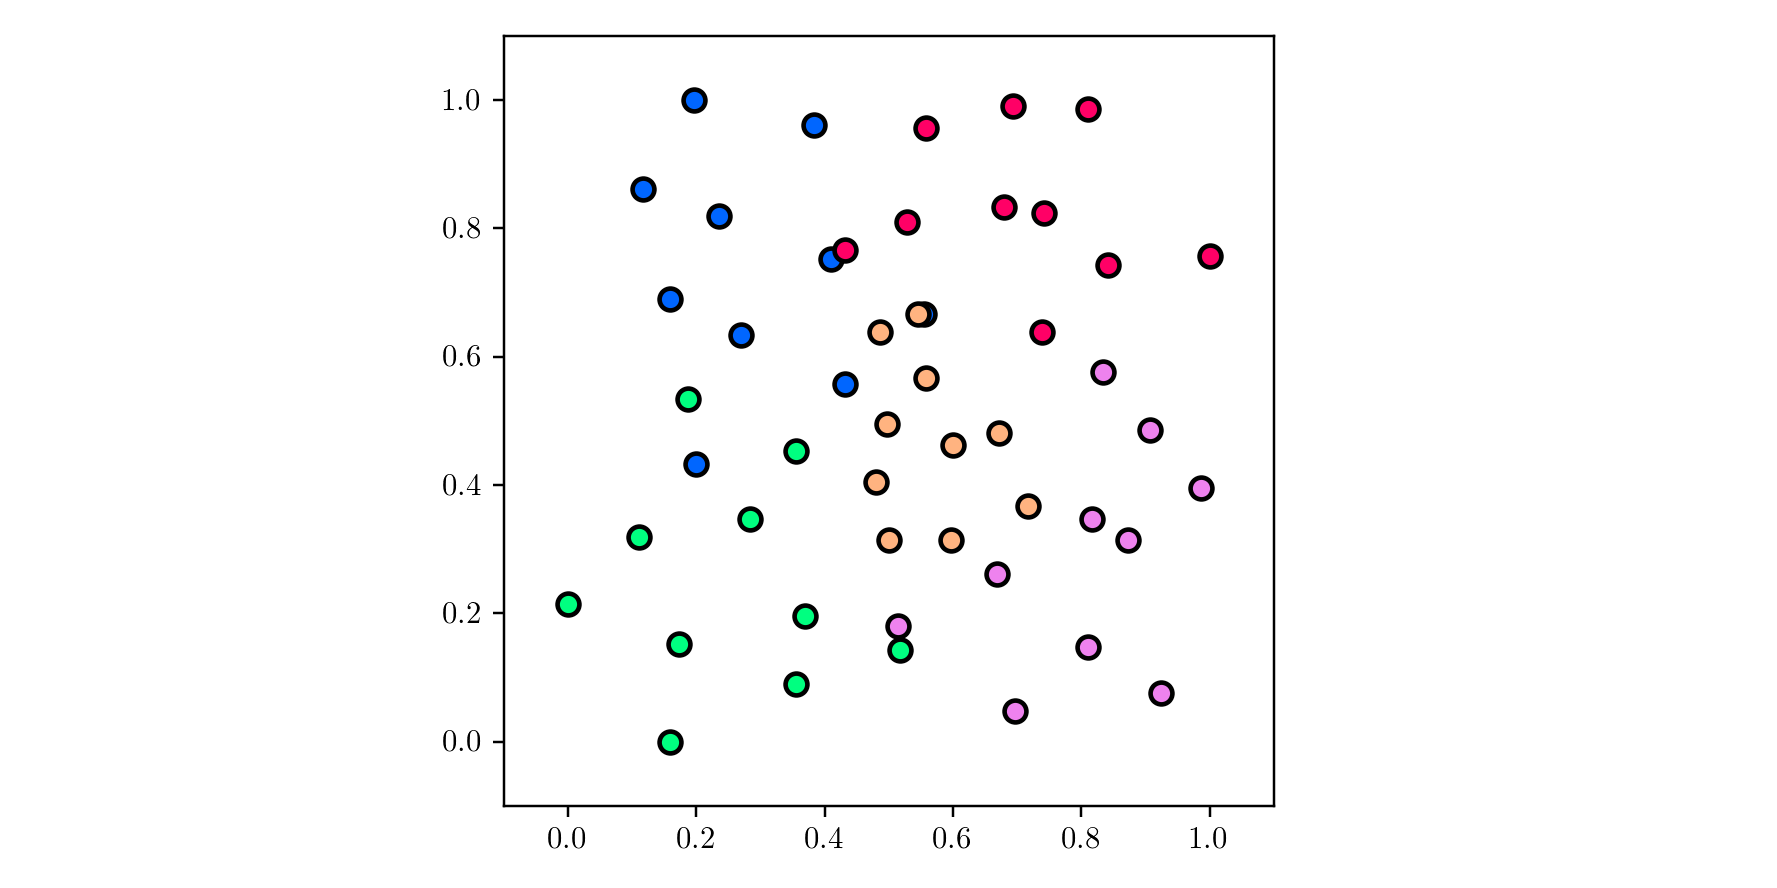

In [39]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
data = np.loadtxt(datapath + '5class_data.csv',delimiter = ',')

# create an instance of the ova demo
demo = superlearn.ova_illustrator.Visualizer(data)

# visualize dataset
demo.show_dataset()

Think for a moment how the OvA approach will perform *in terms of the kahki colored class*.  In particular, think of how the subproblem in which we distinguish between members of this class and all others will be solved.  Because this class of data is *surrounded* by members of the other classes - and there fewer members of the khaki class then all other classes combined - the *optimal* classification rule for this subproblem is to *classify all points as non-khaki* (or in other words to *misclassify* the entire kahki class).  This implies that the linear decision boundary will lie *outside* the range of the points shown, with *all points lying on its negative side*.  The resulting individual classifier decision boundaries are shown in the left panel below.  Now because the weights of decision boundary associated with the kahki colored class are tuned *solely based on this subproblem*, this will lead to the *entire kahki class being misclassified in the final OvA solution*.  This is shown below in the right panel of the figure below, along with the fused decision boundary. 

<IPython.core.display.Javascript object>


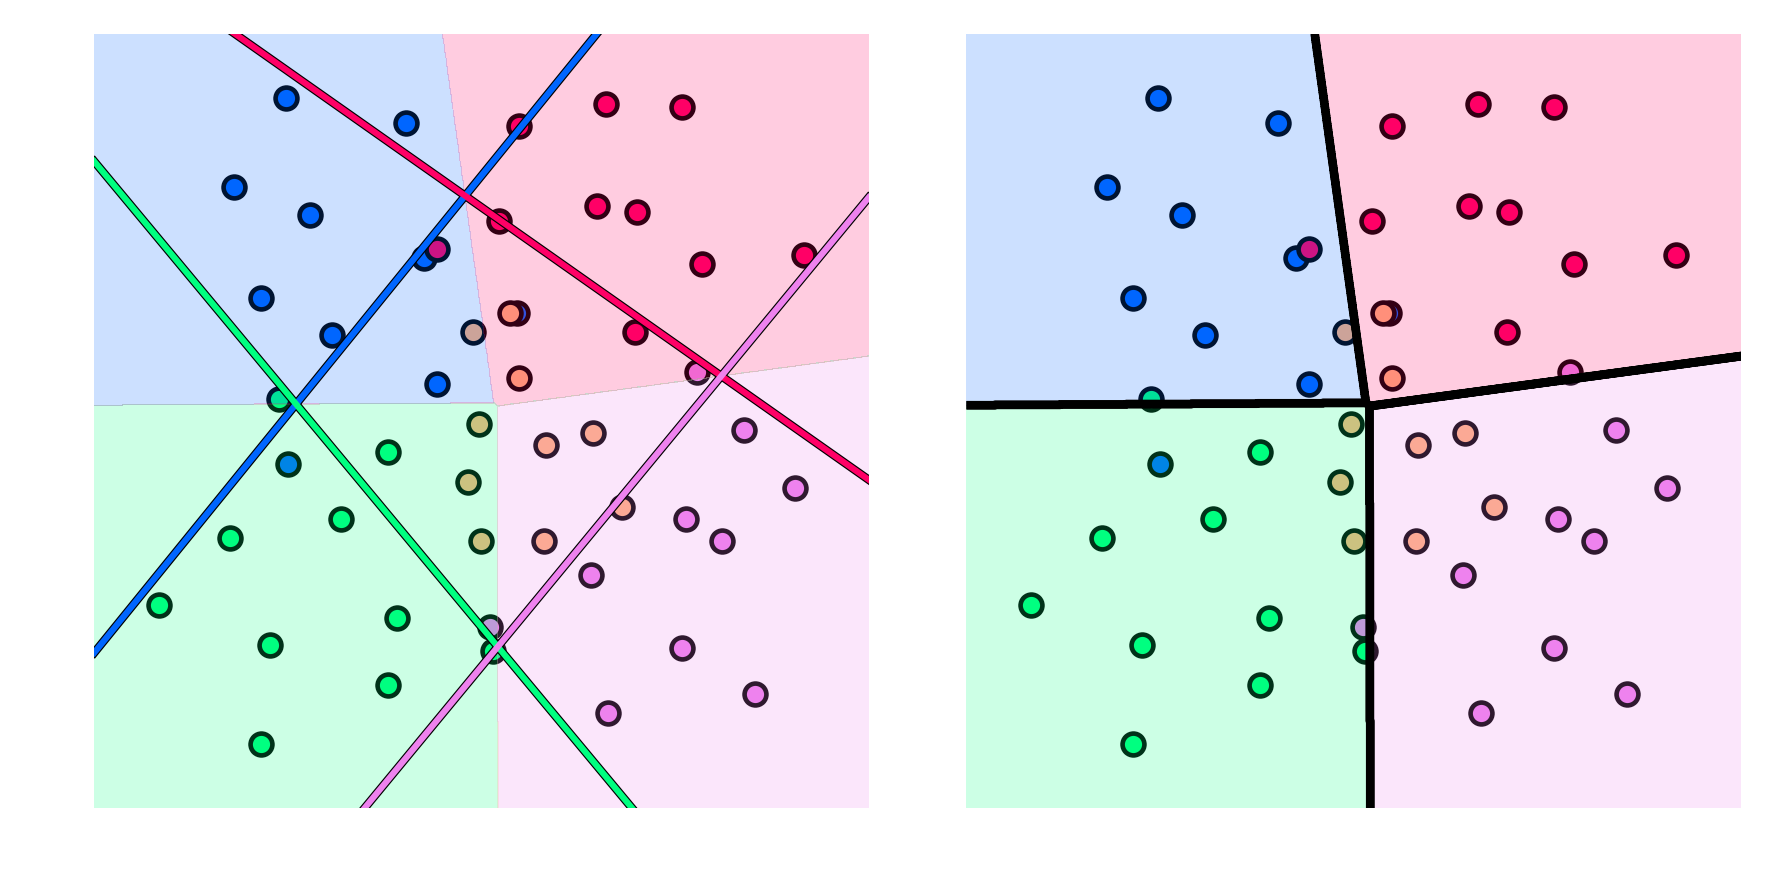

In [35]:
# This code cell will not be shown in the HTML version of this notebook
# create an instance of the ova demo
demo.solve_2class_subproblems()

# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_complete_coloring();

 If - on the other hand - we employ the Multi-class Perceptron or Softmax approach we will not miss this class.  Here - because we tune all weights *together* in order to minimize the number of misclassifications over the entire dataset - we end with final fused decision boundary that is far superior to the one provided by OvA (shown in the right panel below).  We misclassify far fewer points and - in particualr - do *not* misclassify the entire khaki class of data.  We show the individual linear decision boundaries found here as well in the left panel.  While the decision boundary associated with the khaki class lies outside the range of the datapoints, because we have tuned everything together weights in other individual decision boundaries are *adjusted to better satisfy our goal of minimizing misclassifications*.

<IPython.core.display.Javascript object>


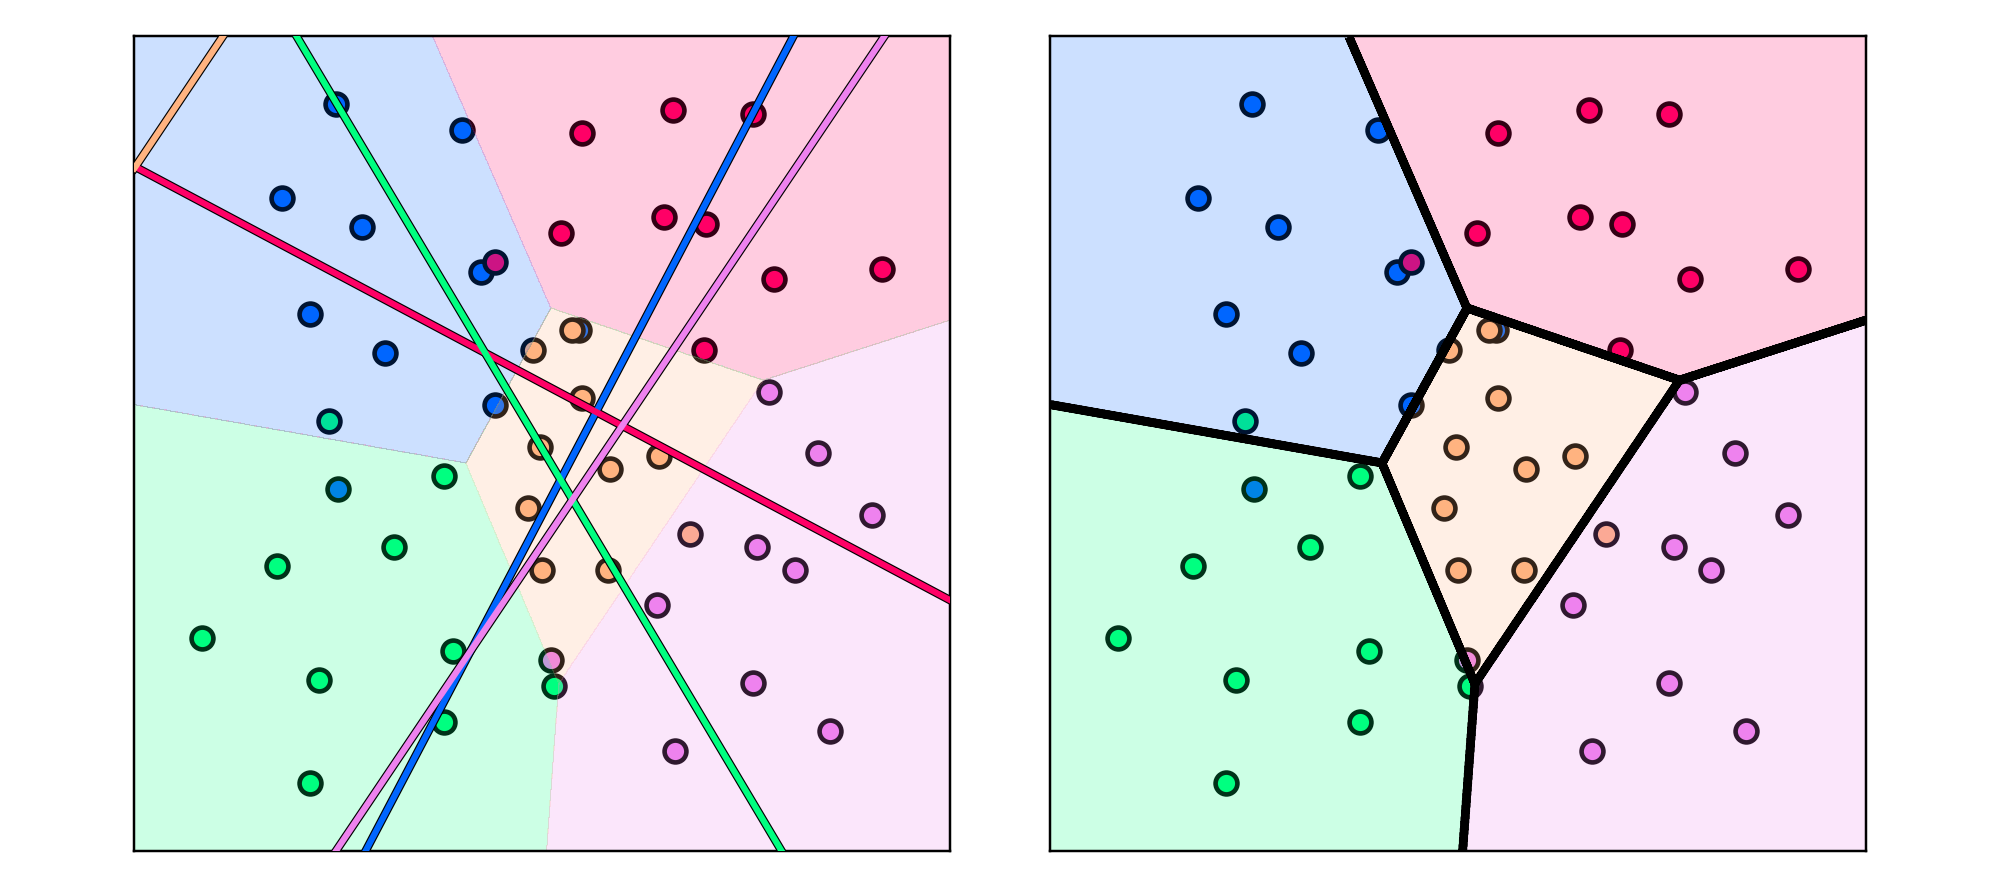

In [37]:
# This code cell will not be shown in the HTML version of this notebook
# compute C linear combinations of input point, one per classifier
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

# multiclass softmaax regularized by the summed length of all normal vectors
lam = 10**(-5)  # our regularization paramter 
def multiclass_softmax(w):        
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute softmax across data points
    a = np.log(np.sum(np.exp(all_evals),axis = 0)) 
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))]
    cost = np.sum(a - b)
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    return cost/float(np.size(y))

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# run newtons method to minimize cost
g = multiclass_softmax; w = 0.1*np.random.randn(3,5); max_its = 5; 
weight_history,cost_history = optimizers.newtons_method(g,max_its,w)

# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo2 = superlearn.multiclass_illustrator.Visualizer(data)
demo2.show_complete_coloring(weight_history, cost = multiclass_softmax)